# Hough Transform
Steps for the implementation of the [Hough transform](https://en.wikipedia.org/wiki/Hough_transform)
1. If the input image is a raster image, compute the edge detection of the input image. The result is a binary image.
2. Through each point $(x_0, y_0)$ in the image pass infinite candidate lines. If any of such lines pass through one or more other points in the image, that line likely represents a real one that goes through all those points in the image. 
3. Each set of infinite lines that pass through a point $(x_0, y_0)$ in the image can be represented as a single line in parameter space (s, d) where s is the slope and d, the intersect is the dependent variable

$$ d = y_0 - x_0 s$$

4. If two points in the image belong to the same line, it means that their representations in the parameter space must match for a certain value of the slope s and the intercept d. So we can solve the problem of finding a line that goes through a certain number of points in the image by solving the problem of finding the lines that intersects in the parameter space. The more lines intersect in a specific point $(s_0, d_0)$ of the parameter space the more point in the image belong to the same line with slope $s_0$ and intersect $d_0$ in the image. We can count the number of intersection by simply adding, for each point of the image, all the points of the line that represent it. A point in the parameter space with a high number of counts represents a line in the image that passes through a high number of pixels. We can use an accumulator matrix to plot the lines in the paramenter space and count those elements through which pass a high number of lines.
5. Since the linear parametrization is unbounded for vertical or near vertical lines, we use the Hessian parametrization that uses the orientation angle $\theta$ and distance $\rho$ of the line from the origin of the coordinates system. A point $(x_0, y_0)$ of an image that belongs to a line with slope s and intersect d satisfies the equation

$$ \rho = x_0 cos(\theta) + y_0 sin(\theta) $$

where $\theta$ is the angle between the x axis and the normal to the line, and $\rho$ is the distance of the line from the origin. So a point $(x_0, y_0)$ in the image can be represented by a sinusoidal function in the parameter space $(\theta, \rho)$ using the Hessian form. If two points belong to the same line in the image, their representations as sinusoidal functions in the parameter space must intersect at a certain point $(\theta_0, \rho_0)$. 

In [2]:
import numpy as np
import math
import skimage
from skimage import io
from skimage import filters
from skimage import util
import matplotlib as mpl
import matplotlib.pyplot as plt
from ipynb.fs.full.shapes import dip_line
from platform import python_version
print("python version: %s"%python_version())
print("numpy version: %s"%np.__version__)
#print("pandas version: %s"%pd.__version__)
print("skimage version: %s"%skimage.__version__)
print("matplotlib version: %s"%mpl.__version__)

python version: 3.8.2
numpy version: 1.18.1
skimage version: 0.17.2
matplotlib version: 3.3.1


## Scikit-image implementation

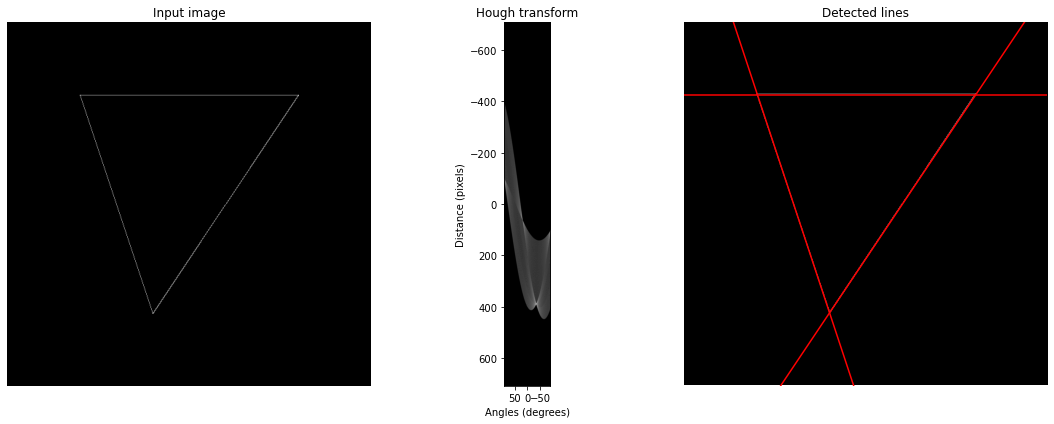

In [3]:
from skimage.transform import hough_line, hough_line_peaks
from matplotlib import cm

# Constructing test image
line1 = dip_line(1, 1, 2, 4)
line2 = dip_line(1, 1, 4, 1)
line3 = dip_line(2, 4, 4, 1)
image = line1 + line2 + line3
 
# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
h, theta, d = hough_line(image, theta=tested_angles)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()


# figure 2
ax[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.gray, aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

# figure 3
ax[2].imshow(image, cmap=cm.gray)
origin = np.array((0, image.shape[1]))
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[2].plot(origin, (y0, y1), '-r')
ax[2].set_xlim(origin)
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

In [35]:
def hessian(u, v):
    num_angles = 180
    theta = np.linspace(0, np.pi, num_angles)
    r = u * np.cos(theta) + v * np.sin(theta)
    theta = np.rad2deg(theta).astype(int) # quantized angle
    #r = N / 2 + np.rint(r * maxDistance / N).astype(int) # quantized distance
    return theta, r

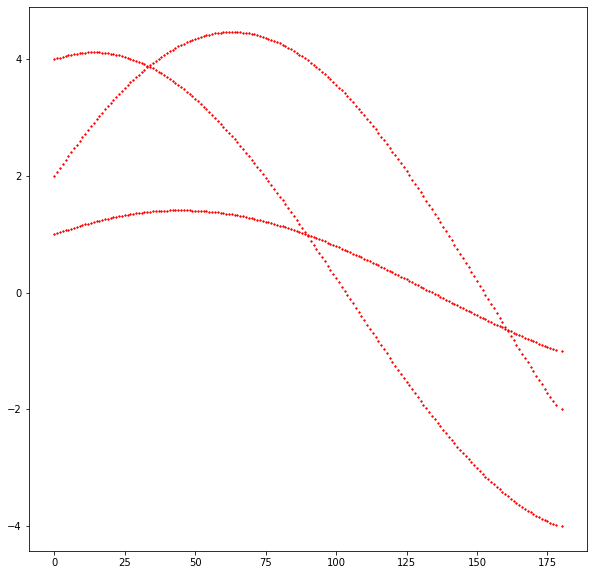

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
#x = [2, 3, 4, 5, 6, 1, 2, 3, 4, 5]
#y = [0, 1, 2, 3, 4, 4, 3, 2, 1, 0]
x = [1, 2, 1, 4, 2, 4]
y = [1, 4, 1, 1, 4, 1]
for i in range(0, len(x)):
    theta, r = hessian(x[i], y[i])
    ax.plot(theta, r, color='red', marker='o', linestyle='None', markersize=1)

#ax.plot(theta, r2, color='red', marker='o', linestyle='None', markersize=1)
#ax.plot(theta, r3, color='red', marker='o', linestyle='None', markersize=1)
#ax.axis((-90, 90, 0, 3))

Computes the hessian transform of a candidate pixel that can belong to lines in the image. The fuction computes the sinusoidal transform and returns the quantized values for $\theta$ and $\rho$

In [110]:
def hessian2(u, v, M, N): 
    '''
    M = rows (y), N = columns (x)
    u = row (y) index, v = column (x) index
    '''
    max_r = np.sqrt(M * M + N * N)
    delta_r = max_r / M
    Yr = M / 2 # parameter space vertical axes origin
    Xr = N / 2 # parameter space horizontal axes origin
    num_angles = 180
    theta = np.linspace(0, np.pi, num_angles)
    r = (v - Xr) * np.cos(theta) + (u - Yr) * np.sin(theta)
    theta = np.rad2deg(theta).astype(int) # quantized angle
    r = np.rint(Yr + r / delta_r).astype(int) # quantized distance
    return theta, r

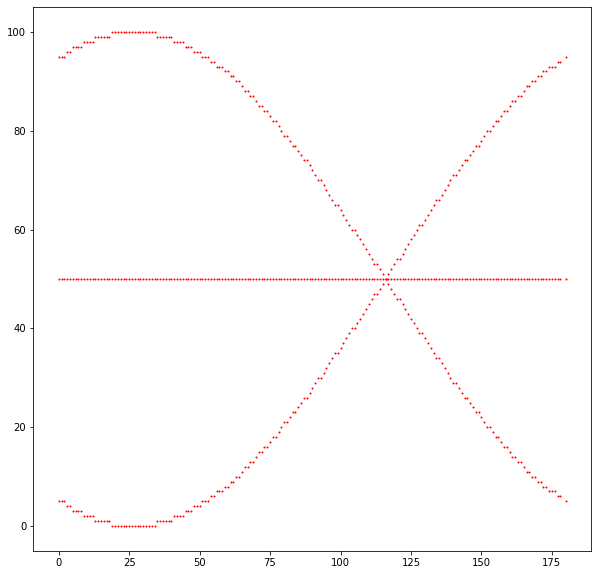

In [111]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
x = [0, 100, 50]
y = [0, 200, 100] # y = (1/2) x
#x = [1, 2, 1, 4, 2, 4]
#y = [1, 4, 1, 1, 4, 1]
for i in range(0, len(x)):
    theta, r = hessian2(x[i], y[i], 100, 200)
    ax.plot(theta, r, color='red', marker='o', linestyle='None', markersize=1)

Now we create a two-dimensional array to be used as accumulator of the Hough transforms in Hessian form of the candidate pixels on which we store the number of times each cell contains a point of any such transform.

In [121]:
def accumulate(u, v, M, N):
    '''
    u and v are lists that contains the coordinates of candidate pixels 
    that can belong to a line in the image.
    M is the number of rows of the image, N is the number of columns
    theta and rho are arrays that contains the coordinates of the Hough 
    transform in Hessian form of a pixel 
    '''
    num_angles = 180
    accumulator = np.zeros((M + 1, num_angles + 1), dtype=int)
    for c in range(0, len(u)):
        theta, rho = hessian2(u[c], v[c], M, N)
        for t in range(0, num_angles):
            i = rho[t]
            j = theta[t]
            accumulator[i, j] += 1
    return accumulator

In [123]:
acc = accumulate(x, y, 100, 200)
acc.max()

3

We want to extract the cells $(\theta, \rho)$ in the accumulator that are more likely to represent a line in the image. We take the cells with a value that is above a certain threshold

In [124]:
def candidateLines(accumulator, threshold):
    M = accumulator.shape[0]
    N = accumulator.shape[1]
    counter = 0
    theta = []
    rho = []
    for r in range(0, M):
        for t in range(0, N):
            if accumulator[r, t] > threshold:
                theta.append(t)
                rho.append(r)
    return theta, rho

In [134]:
theta, rho = candidateLines(acc, 2)
print(theta, rho)
theta[0] * np.pi / 180

[116] [50]


2.0245819323134224

## Hough Transform

In [14]:
def hough_transform(x0, y0, accumulator):
    scale = 100
    acc_size = 500
    num_points = 360

    theta = np.linspace(0, np.pi / 2, num_points)
    r = x0 * np.cos(theta) + y0 * np.sin(theta)
    theta = np.rint(scale * theta).astype(int)
    r = np.rint(scale * r).astype(int)

    points = np.zeros((num_points, 2), dtype=int)
    for i in range(0, num_points):
        points[i, 0] = theta[i]
        points[i, 1] = r[i]

    #accumulator = np.zeros((acc_size, acc_size), dtype=int)
    for i in range(0, num_points):
        row = points[i, 1]
        col = points[i, 0]
        accumulator[row, col] += 1
    return accumulator

(1, 2, 3)

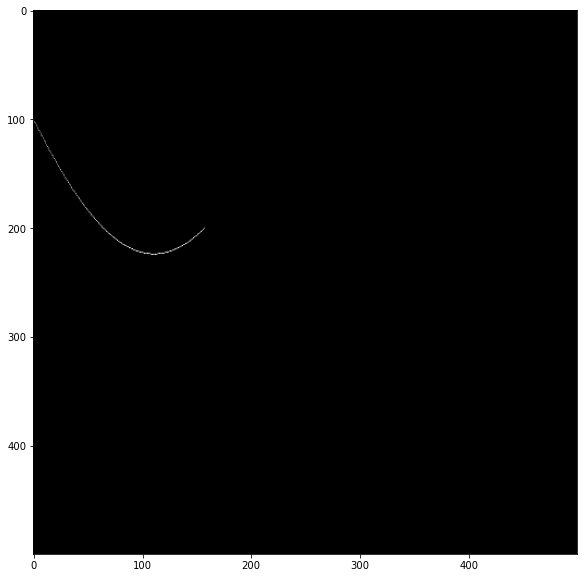

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
accumulator = np.zeros((500, 500), dtype=int)
num_points = 1
x = 1 #+ 0.1 * np.random.rand(num_points)
y = 2 #+ 0.1 * np.random.rand(num_points)
#for i in range(0, num_points):
accumulator = hough_transform(x, y, accumulator)
ax.imshow(accumulator, cmap=cm.gray)
x, y, accumulator.max()

## References
[Duda, Hart - Use of the Hough Transformation to Detect Lines and Curves in Pictures](https://www.cse.unr.edu/~bebis/CS474/Handouts/HoughTransformPaper.pdf)